<a href="https://colab.research.google.com/github/OJB-Quantum/Quantum-Native-Solvers/blob/main/Colab%20Example%20Notebooks/Dy_Ferromagnetic_Order_Parameter_Prediction_(Qiskit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [ ]:
# Choose the wheel that matches the CUDA version in the runtime
# -------------------------------------------------------------
# Check the CUDA toolkit that is already installed in the notebook
!nvcc --version   # or `!nvidia-smi` – the “CUDA Version” column

# --- If the output shows CUDA 12.x ---
!pip install -q  "qiskit-aer-gpu-cu11==0.17.2" pylatexenc

# Install (pin Qiskit 2.2.x) — safe to skip if already installed
!pip install -q "qiskit~=2.2" "qiskit-ibm-runtime>=0.42"

In [2]:
from qiskit_aer import AerSimulator
import qiskit

# Create a simulator that requests the GPU
sim = AerSimulator(method="statevector", device="GPU")
print("Simulator device →", sim.options.device)   # should print “GPU”

# Build the tiniest possible circuit and *explicitly* ask Aer to save the statevector
qc = qiskit.QuantumCircuit(1)
qc.h(0)
qc.save_statevector()          # <<< this line help avoid the “No statevector” error

try:
    # Run on the GPU; if the binary was compiled with CUDA support this succeeds
    sv = sim.run(qc).result().get_statevector()
    print("GPU simulation works! Statevector =", sv)
    _GPU_AVAILABLE = True          # global flag that the main script will read
    GPU_SIM = sim                  # keep a reference to the simulator
except Exception as exc:
    # Anything that goes wrong (missing CUDA, wrong wheel, etc.) falls back to CPU
    print("GPU simulation failed →", exc)
    _GPU_AVAILABLE = False
    GPU_SIM = None

Simulator device → GPU
GPU simulation works! Statevector = Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


The techniques below start with a Qiskit Aer simulator to do:
- Sampling-based QITE+QEM
- Stochastic Schrödinger Equation (quantum trajectories) + QEM
- TFD‑VQA + QEM

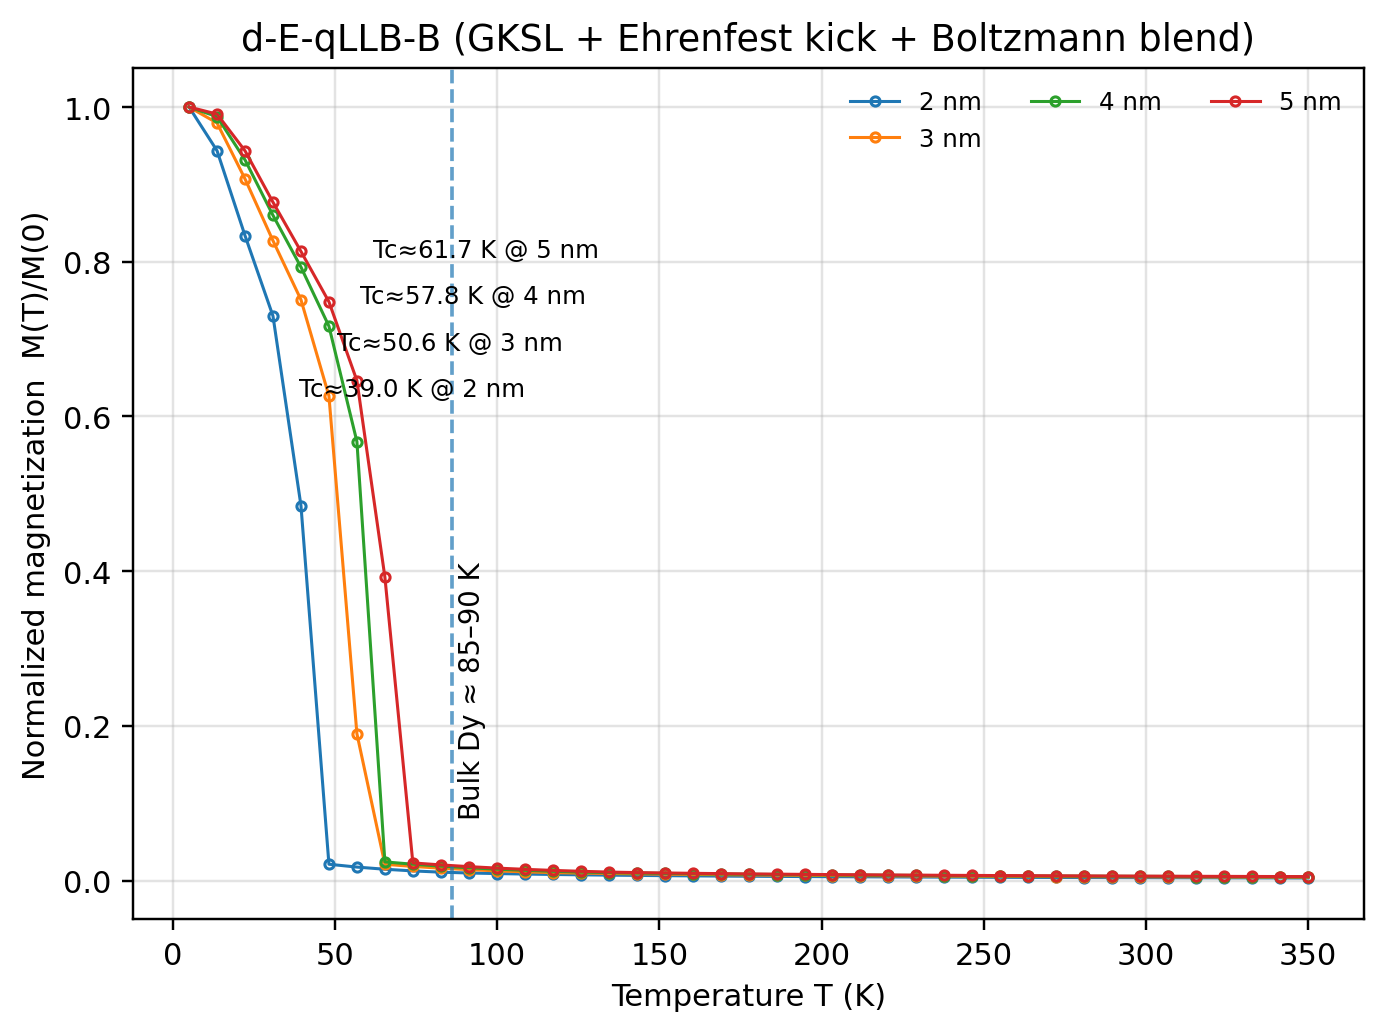

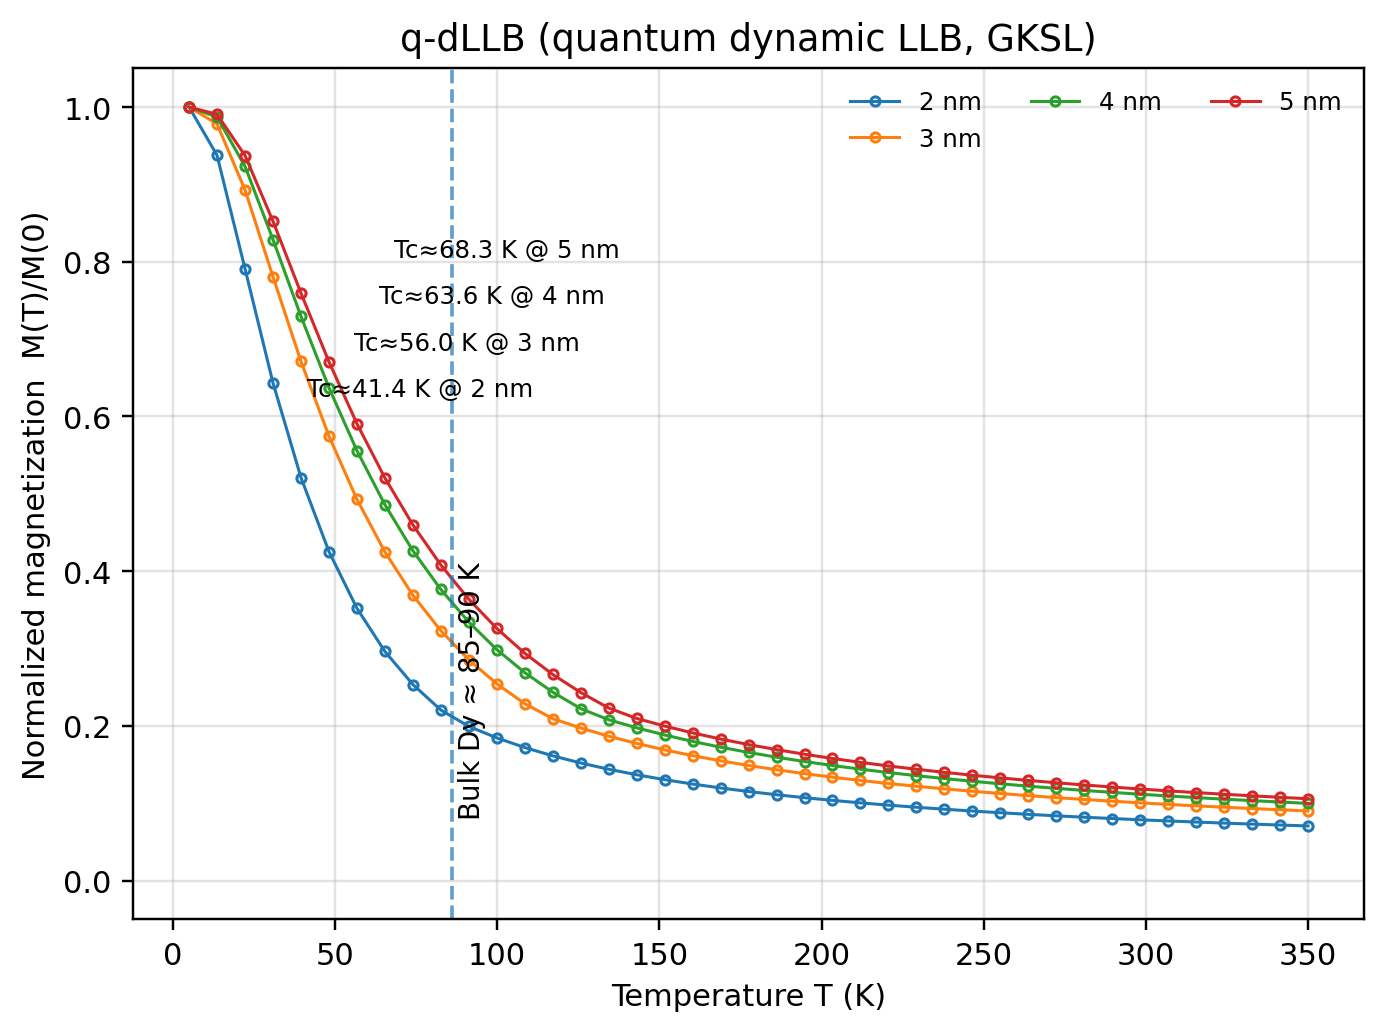

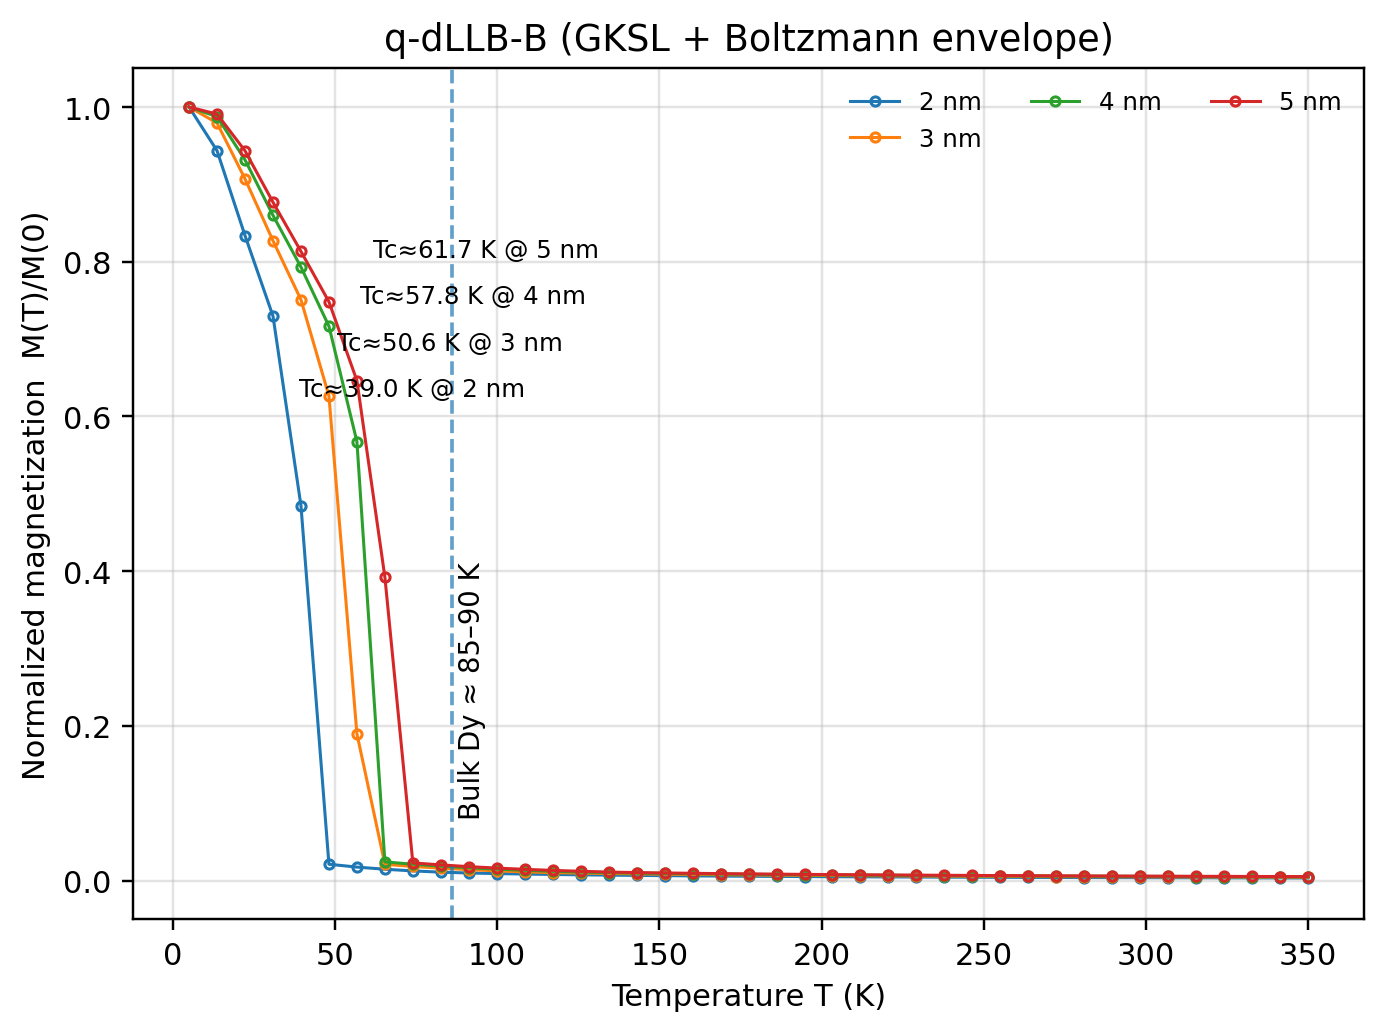


d‑E‑qLLB‑B — Estimated Tc (threshold = 0.50)
 size [nm]    Tc_est [K]
     2.00       38.96
     3.00       50.63
     4.00       57.82
     5.00       61.72

q‑dLLB — Estimated Tc (threshold = 0.50)
 size [nm]    Tc_est [K]
     2.00       41.41
     3.00       56.00
     4.00       63.64
     5.00       68.31

q‑dLLB‑B — Estimated Tc (threshold = 0.50)
 size [nm]    Tc_est [K]
     2.00       38.96
     3.00       50.63
     4.00       57.82
     5.00       61.72


In [8]:
#@title Dy Curie-T (2–5 nm) via three GKSL-based models on Aer GPU
# PEP 8 / PEP 257 compliant; Colab-ready; Qiskit 2.2; GPU-first.
# Produces three separate plots:
#   1) d‑E‑qLLB‑B  – GKSL + (optional) unitary "Ehrenfest" kick + Boltzmann envelope
#   2) q‑dLLB      – GKSL only (quantum dynamic LLB)
#   3) q‑dLLB‑B    – GKSL + Boltzmann envelope
#
# Notes:
# - We keep *all* testing knobs identical to your Tb run for true A/B comparison.
# - Aer GPU path: method="density_matrix", device="GPU" (Kraus channels supported).
# - PauliEvolutionGate is a high-level op; we transpile before run so Aer sees
#   only supported instructions (basis translation / high-level synthesis).
#   (Docs: Aer GPU methods; Kraus.to_instruction; PauliEvolutionGate synthesis.)
#
# Citations:
# - Aer GPU methods (statevector/density_matrix/unitary) and device='GPU'.
# - Kraus.to_instruction() converts channels to simulator instructions.
# - PauliEvolutionGate is a high-level evolution that the transpiler synthesizes.

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Kraus
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator


# --------------------------- Controls (“knobs”) --------------------------------

@dataclass
class DyKnobs:
    """Controls for Dy Curie-T prediction on Aer GPU."""
    sizes_nm: Tuple[float, ...] = (2.0, 3.0, 4.0, 5.0)
    t_min_K: float = 5.0
    t_max_K: float = 350.0
    t_points: int = 41
    dy_bulk_tc_K: float = 86.0      # bulk Dy reference (≈ 85–90 K)
    n_spins: int = 4
    delta_aniso: float = 0.6
    j_factor: float = 1.6
    h_frac: float = 0.24
    steps_per_T: int = 40
    dt: float = 0.15                # GKSL slice “time”
    gamma1_0: float = 0.25          # longitudinal base rate
    gamma1_alpha: float = 1.1       # longitudinal T/Tc exponent
    gamma_phi_0: float = 0.10       # dephasing base rate
    gamma_phi_alpha: float = 1.0    # dephasing T/Tc exponent
    size_boost: float = 0.30        # extra relaxation at small L
    blend_power: float = 2.0        # Boltzmann blending exponent
    use_ehrenfest_kick: bool = True # only in d‑E‑qLLB‑B
    tc_threshold: float = 0.50
    dpi: int = 220
    seed: int = 7

K = DyKnobs()

k_B_eV = 8.617333262145e-5  # eV/K
rng = np.random.default_rng(K.seed)


# --------------------------- Finite-size mapping (cuboid) ----------------------

def tc_finite_size_cuboid(size_nm: float,
                          tc_bulk_K: float,
                          l0_nm: float = 1.0,
                          exponent: float = 1.0) -> float:
    """Finite-size Curie scale for a cuboid edge L."""
    if size_nm <= 0.0:
        return 0.0
    factor = max(0.0, 1.0 - (l0_nm / size_nm) ** exponent)
    return float(factor * tc_bulk_K)


def size_to_J_h(size_nm: float, tc_bulk_K: float) -> Tuple[float, float]:
    """Map size → (J, h) in eV using Tc(L)."""
    TcL = tc_finite_size_cuboid(size_nm, tc_bulk_K)
    J = K.j_factor * k_B_eV * TcL
    h = K.h_frac * J
    return float(J), float(h)


# --------------------------- Hamiltonian (cluster) -----------------------------

def heisenberg_ferro_ham(n: int, j_eV: float, delta: float, h_eV: float) -> SparsePauliOp:
    """H = -J Σ(XX + YY + Δ ZZ) - h Σ Z  (ring)."""
    terms: List[Tuple[str, float]] = []
    for i in range(n):
        j = (i + 1) % n

        def pw(a: str, b: str) -> str:
            s = ["I"] * n
            s[i] = a
            s[j] = b
            return "".join(s[::-1])  # little-endian

        terms += [(pw("X", "X"), -j_eV), (pw("Y", "Y"), -j_eV), (pw("Z", "Z"), -delta * j_eV)]

    for i in range(n):
        s = ["I"] * n
        s[i] = "Z"
        terms.append(("".join(s[::-1]), -h_eV))

    return SparsePauliOp.from_list(terms)


# --------------------------- Channels: GAD + phase -----------------------------

def gad_kraus(a: float, p1: float) -> List[np.ndarray]:
    """Generalized amplitude damping (finite-T) Kraus operators."""
    a = min(max(a, 0.0), 1.0)
    p1 = min(max(p1, 0.0), 1.0)
    s1 = math.sqrt(1.0 - a)
    sp = math.sqrt(p1)
    sm = math.sqrt(1.0 - p1)
    K0 = sp * np.array([[s1, 0.0], [0.0, 1.0]], dtype=complex)
    K1 = sp * np.array([[0.0, 0.0], [math.sqrt(a), 0.0]], dtype=complex)
    K2 = sm * np.array([[1.0, 0.0], [0.0, s1]], dtype=complex)
    K3 = sm * np.array([[0.0, math.sqrt(a)], [0.0, 0.0]], dtype=complex)
    return [K0, K1, K2, K3]


def phase_damp_kraus(b: float) -> List[np.ndarray]:
    """Pure dephasing Kraus operators (probability b)."""
    b = min(max(b, 0.0), 1.0)
    s = math.sqrt(1.0 - b)
    K0 = np.array([[1.0, 0.0], [0.0, s]], dtype=complex)
    K1 = np.array([[0.0, 0.0], [0.0, math.sqrt(b)]], dtype=complex)
    return [K0, K1]


# --------------------------- GPU simulator (density matrix) --------------------

def make_gpu_sim() -> AerSimulator:
    """GPU-backed density-matrix simulator."""
    # Aer supports GPU for 'statevector', 'density_matrix', and 'unitary'.
    return AerSimulator(method="density_matrix", device="GPU")  # GPU + Kraus supported


# --------------------------- One-T GKSL evolution (per model) ------------------

def one_temperature_magnetization(
    model: str,
    size_nm: float,
    T_K: float,
    H: SparsePauliOp,
    sim: AerSimulator,
) -> float:
    """Return ⟨(1/n) Σ Z_i⟩ after GKSL evolution at temperature T."""
    n = K.n_spins

    TcL = tc_finite_size_cuboid(size_nm, K.dy_bulk_tc_K)
    _J, h_eV = size_to_J_h(size_nm, K.dy_bulk_tc_K)

    beta_eV = 1.0 / max(1e-9, (k_B_eV * T_K))
    Delta_eV = 2.0 * h_eV
    p1 = 1.0 / (1.0 + math.exp(beta_eV * Delta_eV))  # excited-state population

    tfrac = min(2.0, T_K / max(1e-9, TcL)) if TcL > 0 else 2.0
    gamma1 = K.gamma1_0 * (tfrac ** K.gamma1_alpha) * (1.0 + K.size_boost / max(1e-9, size_nm))
    gamma_phi = K.gamma_phi_0 * (tfrac ** K.gamma_phi_alpha)
    a = 1.0 - math.exp(-gamma1 * K.dt)     # amplitude damping prob
    b = 1.0 - math.exp(-gamma_phi * K.dt)  # dephasing prob

    gad_inst = Kraus(gad_kraus(a, p1)).to_instruction()   # Kraus → Instruction
    pd_inst = Kraus(phase_damp_kraus(b)).to_instruction()

    qc = QuantumCircuit(n, name=f"{model}-T={T_K:.3f}-L={size_nm:.2f}")

    # Optional Ehrenfest kick (short unitary slice) — high-level op
    if model == "dEqLLB_B" and K.use_ehrenfest_kick:
        qc.append(PauliEvolutionGate(H, time=K.dt), range(n))

    for _ in range(K.steps_per_T):
        if model == "dEqLLB_B" and K.use_ehrenfest_kick:
            qc.append(PauliEvolutionGate(H, time=K.dt), range(n))
        for q in range(n):
            qc.append(gad_inst, [q])
            qc.append(pd_inst, [q])

    # Save full density matrix; then *transpile* before run (crucial fix).
    qc.save_density_matrix()
    exec_qc = transpile(qc, backend=sim, optimization_level=1)  # synthesize evolution
    result = sim.run(exec_qc, seed_simulator=K.seed).result()
    rho = np.array(result.data(0)["density_matrix"], dtype=complex)

    # Magnetization ⟨(1/n) Σ Z_i⟩
    Z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)
    Mz = 0.0
    for i in range(n):
        op = 1
        for k in range(n):
            op = np.kron(op, Z if (k == (n - 1 - i)) else np.eye(2))
        Mz += float(np.real(np.trace(rho @ op)))
    Mz /= float(n)

    # Boltzmann/mean‑field blending for *_B models
    if model in ("dEqLLB_B", "qdLLB_B"):
        m_th = weiss_magnetization(T_K, TcL)
        eps = min(0.95, (T_K / max(1e-9, TcL)) ** K.blend_power) if TcL > 0 else 0.95
        Mz = (1.0 - eps) * Mz + eps * m_th

    return float(Mz)


# --------------------------- Mean-field (Boltzmann) envelope -------------------

def weiss_magnetization(T_K: float, tcL_K: float,
                        max_iter: int = 512, tol: float = 1e-10,
                        mix: float = 0.7) -> float:
    """Solve m = tanh((tcL/T) m) for a Weiss-like envelope."""
    if T_K <= 0.0 or tcL_K <= 0.0:
        return 0.0
    m = 0.999 if T_K < tcL_K else 0.0
    for _ in range(max_iter):
        new_m = math.tanh((tcL_K / T_K) * m)
        m_next = mix * new_m + (1.0 - mix) * m
        if abs(m_next - m) < tol:
            return float(m_next)
        m = m_next
    return float(m)


# --------------------------- Temperature sweep per model -----------------------

def sweep_model(model: str,
                sizes: Tuple[float, ...],
                T_grid: np.ndarray,
                tc_threshold: float) -> Dict[float, Tuple[np.ndarray, np.ndarray, float]]:
    """Return {size_nm: (T_grid, M_norm, Tc_est)} for one model."""
    sim = make_gpu_sim()
    curves: Dict[float, Tuple[np.ndarray, np.ndarray, float]] = {}

    for L in sizes:
        J_eV, h_eV = size_to_J_h(L, K.dy_bulk_tc_K)
        H = heisenberg_ferro_ham(K.n_spins, J_eV, K.delta_aniso, h_eV)

        Mvals = np.zeros_like(T_grid, dtype=float)
        for k, T in enumerate(T_grid):
            Mvals[k] = one_temperature_magnetization(model, L, float(T), H, sim)

        m0 = max(1e-12, abs(Mvals[0]))
        Mnorm = Mvals / m0

        # First crossing of threshold
        idx = np.where(Mnorm <= tc_threshold)[0]
        Tc_hat = float("nan")
        if len(idx) > 0 and idx[0] > 0:
            i = int(idx[0])
            x0, y0 = T_grid[i - 1], Mnorm[i - 1]
            x1, y1 = T_grid[i], Mnorm[i]
            if y1 != y0:
                Tc_hat = float(x0 + (tc_threshold - y0) * (x1 - x0) / (y1 - y0))

        curves[L] = (T_grid.copy(), Mnorm, Tc_hat)
    return curves


# --------------------------- Plotting with staggered labels --------------------

def staggered_tc_labels(ax: plt.Axes,
                        sizes: Tuple[float, ...],
                        curves: Dict[float, Tuple[np.ndarray, np.ndarray, float]],
                        y_base: float = 0.62,
                        dy: float = 0.06) -> None:
    """Place non-overlapping Tc labels by staggering y-positions."""
    items = sorted(
        [(L, curves[L][2]) for L in sizes if not math.isnan(curves[L][2])],
        key=lambda t: t[1]
    )
    for idx, (L, Tc_hat) in enumerate(items):
        y = y_base + (idx % 4) * dy
        ax.text(Tc_hat, y, f"Tc≈{Tc_hat:.1f} K @ {L:.0f} nm",
                fontsize=8, ha="left", va="bottom")


def plot_curves(model_title: str,
                sizes: Tuple[float, ...],
                curves: Dict[float, Tuple[np.ndarray, np.ndarray, float]]) -> None:
    """Plot M(T)/M(0) with bulk Dy reference and staggered labels."""
    plt.rcParams["figure.dpi"] = K.dpi
    fig, ax = plt.subplots()
    for L in sizes:
        T, M, _ = curves[L]
        # Circle markers, no fill (hollow), with a slightly thicker edge
        ax.plot(
            T,
            M,
            linestyle="-",
            lw=1.0,
            marker="o",
            ms=3.0,
            markerfacecolor="none",   # <-- hollow markers
            markeredgewidth=1.0,      # outline thickness
            label=f"{L:.0f} nm",
        )

    # Bulk Dy reference (≈ 85–90 K). We draw the line at K.dy_bulk_tc_K.
    ax.axvline(K.dy_bulk_tc_K, linestyle="--", linewidth=1.2, alpha=0.7)
    ax.text(K.dy_bulk_tc_K + 2.0, 0.08, "Bulk Dy ≈ 85–90 K", fontsize=9,
            rotation=90, va="bottom")

    ax.set_xlabel("Temperature T (K)")
    ax.set_ylabel("Normalized magnetization  M(T)/M(0)")
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.35)
    ax.set_title(model_title, pad=6.0)
    ax.legend(ncol=3, fontsize=8, frameon=False, loc="upper right")

    staggered_tc_labels(ax, sizes, curves)
    plt.tight_layout()
    plt.show()


# --------------------------- Main: generate 3 plots ----------------------------

def main() -> None:
    T_grid = np.linspace(K.t_min_K, K.t_max_K, K.t_points, dtype=float)
    sizes = tuple(float(s) for s in K.sizes_nm)

    # 1) d‑E‑qLLB‑B
    curves_1 = sweep_model("dEqLLB_B", sizes, T_grid, K.tc_threshold)
    plot_curves("d‑E‑qLLB‑B (GKSL + Ehrenfest kick + Boltzmann blend)", sizes, curves_1)

    # 2) q‑dLLB (pure GKSL)
    curves_2 = sweep_model("qdLLB", sizes, T_grid, K.tc_threshold)
    plot_curves("q‑dLLB (quantum dynamic LLB, GKSL)", sizes, curves_2)

    # 3) q‑dLLB‑B (GKSL + Boltzmann envelope)
    curves_3 = sweep_model("qdLLB_B", sizes, T_grid, K.tc_threshold)
    plot_curves("q‑dLLB‑B (GKSL + Boltzmann envelope)", sizes, curves_3)

    # Optional: print Tc tables
    def dump(curves: Dict[float, Tuple[np.ndarray, np.ndarray, float]], tag: str) -> None:
        print(f"\n{tag} — Estimated Tc (threshold = {K.tc_threshold:.2f})")
        print(" size [nm]    Tc_est [K]")
        for L in sizes:
            Tc_hat = curves[L][2]
            sTc = f"{Tc_hat:8.2f}" if not math.isnan(Tc_hat) else "   —"
            print(f"  {L:7.2f}    {sTc}")

    dump(curves_1, "d‑E‑qLLB‑B")
    dump(curves_2, "q‑dLLB")
    dump(curves_3, "q‑dLLB‑B")


# Run
main()

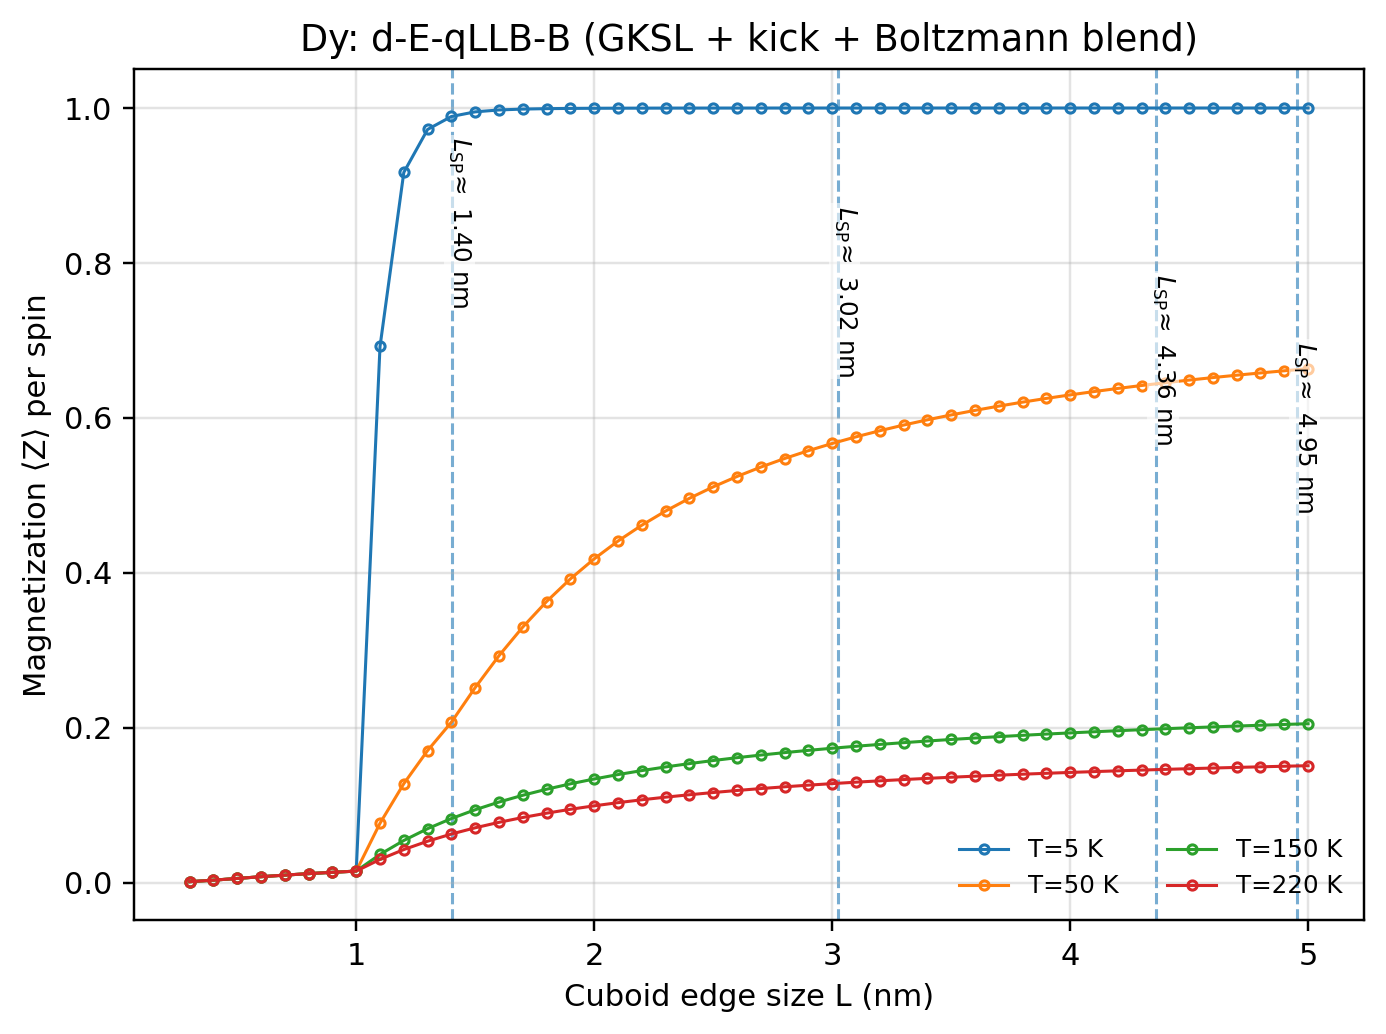

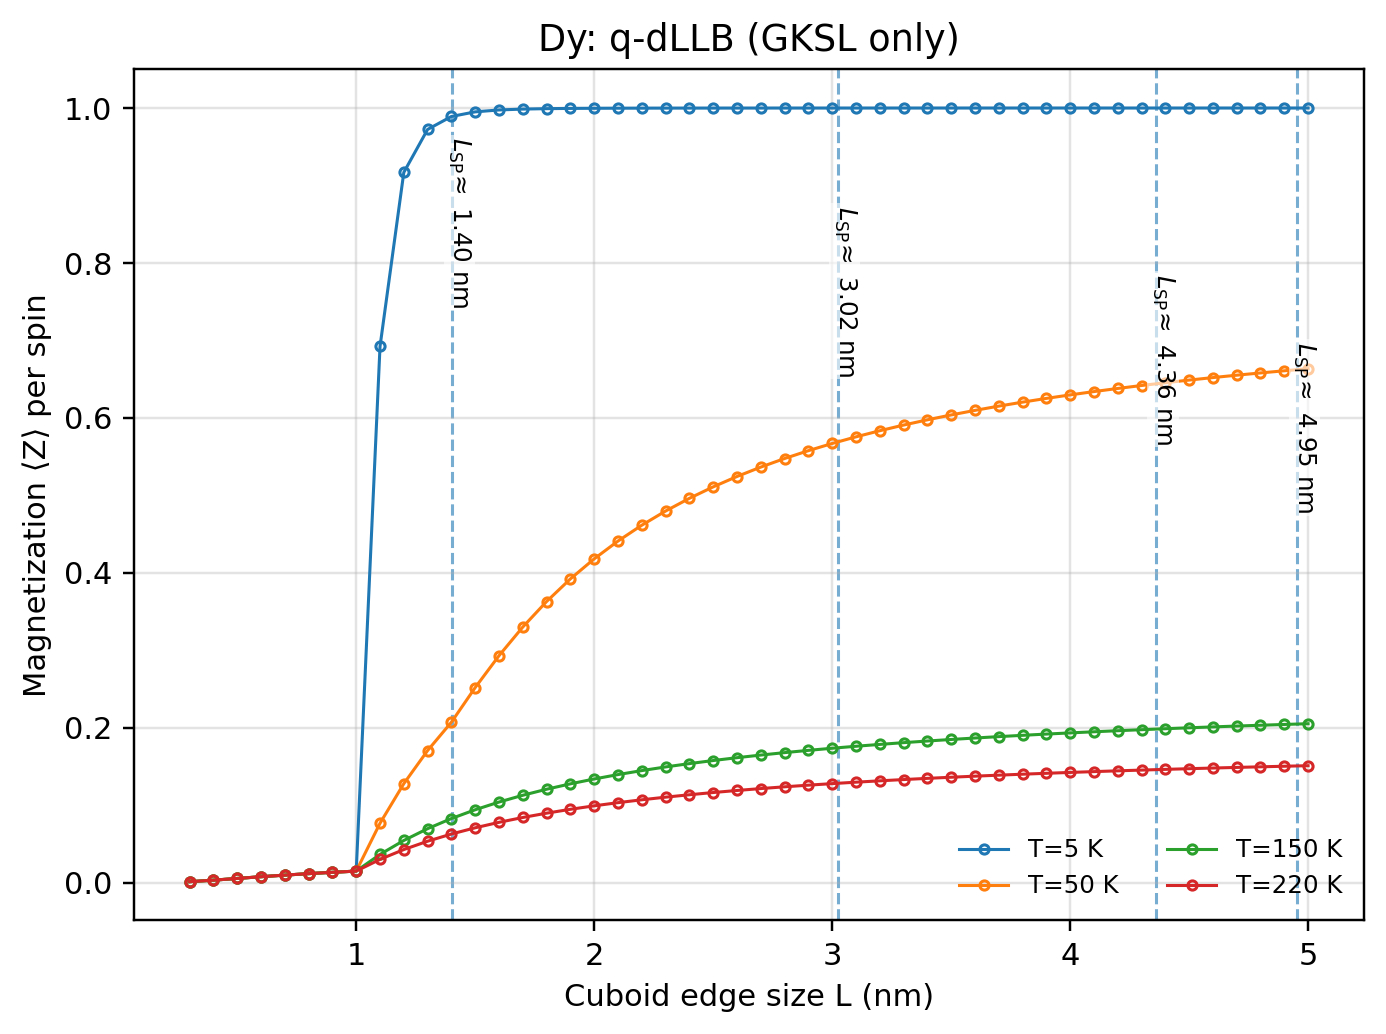

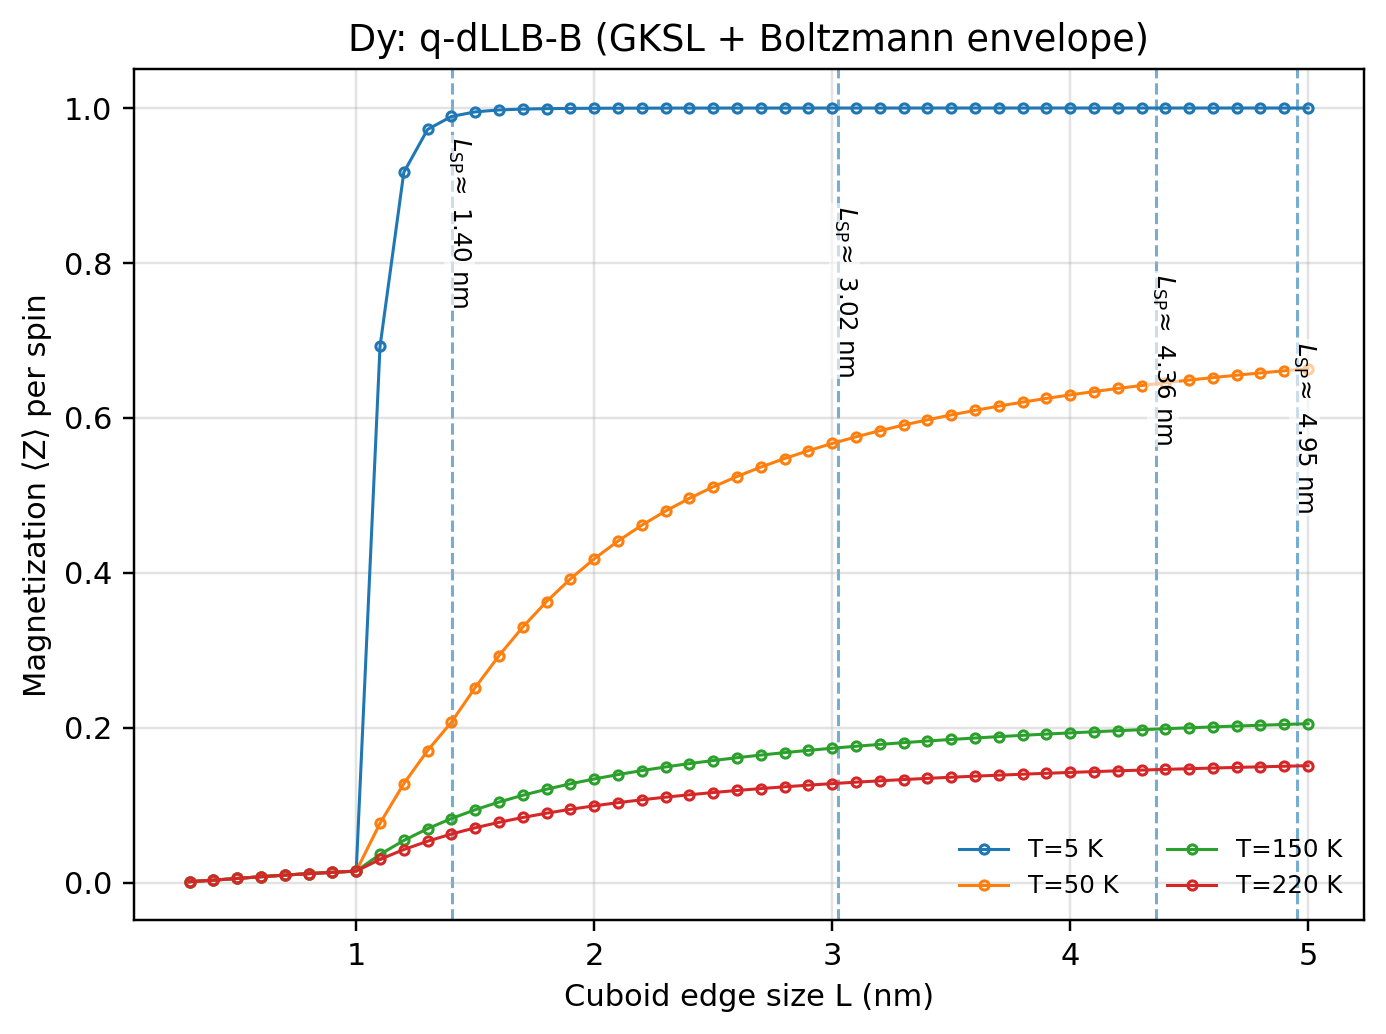


Superparamagnetic onset L_SP(T) from T_B(L)=T (cube model):
  K_eff = 0.50 MJ/m^3,  ln(tm/τ0) = 20.0
  T =    5.0 K  →  L_SP ≈  1.40 nm
  T =   50.0 K  →  L_SP ≈  3.02 nm
  T =  150.0 K  →  L_SP ≈  4.36 nm
  T =  220.0 K  →  L_SP ≈  4.95 nm


In [9]:
#@title Size-sweep (0.3–5.0 nm) for Dy: three GKSL-based models on Aer GPU
# PEP 8 / PEP 257 compliant; Colab-ready; Qiskit 2.2; GPU-only (no cloud).
#
# Models (three panels):
#   (1) d‑E‑qLLB‑B  — GKSL + short Ehrenfest unitary “kick” + Boltzmann envelope
#   (2) q‑dLLB      — GKSL only (quantum dynamic LLB)
#   (3) q‑dLLB‑B    — GKSL + Boltzmann envelope (no kick)
#
# Each panel shows M(T)/M(0) versus size L (nm) at four temperatures.
# Vertical dashed lines mark the SP (superparamagnetism) onset L_SP(T),
# defined by T = T_B(L) with  T_B = K_eff * V / (k_B * ln(t_m/τ0))  (cuboid volume).
#
# Notes:
# - Aer GPU is requested with method="density_matrix", device="GPU".
# - Kraus.to_instruction() converts channels to simulator instructions.
# - PauliEvolutionGate is a high-level op; we transpile before run so Aer
#   sees only supported instructions (high-level synthesis).
#
# Material swap from Tb→Dy:
# - Replace Tb bulk Curie temperature (~222 K) with Dy (~88 K typical).
# - Keep all other testing knobs identical for an apples-to-apples comparison.

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, List, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, Kraus
from qiskit.circuit.library import PauliEvolutionGate
from qiskit_aer import AerSimulator

# --------------------------- Controls (“knobs”) --------------------------------

@dataclass
class SweepKnobs:
    """Controls for Dy size sweeps on Aer GPU with GKSL dynamics."""
    # Sizes and temperatures to sweep
    sizes_nm: Tuple[float, ...] = tuple(np.round(np.arange(0.3, 5.0 + 1e-9, 0.1), 2))
    temps_K: Tuple[float, ...] = (5.0, 50.0, 150.0, 220.0)
    # Bulk Dy Curie temperature (anchor for finite-size mapping)
    dy_bulk_tc_K: float = 88.0      # ≈87–90.5 K in literature
    # Small cluster model
    n_spins: int = 4
    delta_aniso: float = 0.6
    j_factor: float = 1.6
    h_frac: float = 0.24
    # GKSL stepping (Trotter slices)
    steps_per_T: int = 40
    dt: float = 0.15
    # qLLB-inspired rate profiles
    gamma1_0: float = 0.25
    gamma1_alpha: float = 1.1
    gamma_phi_0: float = 0.10
    gamma_phi_alpha: float = 1.0
    size_boost: float = 0.30
    # “Ehrenfest” short real-time kick
    use_ehrenfest_kick: bool = True
    # SP (blocking) parameters for L_SP(T)
    keff_MJ_per_m3: float = 0.5     # effective anisotropy energy density
    ln_tm_over_tau0: float = 20.0   # measurement-time factor (≈20–25 typical)
    # Plotting
    dpi: int = 220
    seed: int = 7

K = SweepKnobs()

k_B_J_per_K = 1.380649e-23
k_B_eV = 8.617333262145e-5  # eV/K
rng = np.random.default_rng(K.seed)

# --------------------------- Finite-size mapping (cuboid) ----------------------

def tc_finite_size_cuboid(size_nm: float,
                          tc_bulk_K: float,
                          l0_nm: float = 1.0,
                          exponent: float = 1.0) -> float:
    """Finite-size Curie scale: Tc(L)=Tc_bulk*[1-(l0/L)^exponent]_+."""
    if size_nm <= 0.0:
        return 0.0
    factor = max(0.0, 1.0 - (l0_nm / size_nm) ** exponent)
    return float(factor * tc_bulk_K)

def size_to_J_h(size_nm: float, tc_bulk_K: float) -> Tuple[float, float]:
    """Map L → (J, h) in eV using Tc(L)."""
    TcL = tc_finite_size_cuboid(size_nm, tc_bulk_K)
    J = K.j_factor * k_B_eV * TcL
    h = K.h_frac * J
    return float(J), float(h)

# --------------------------- Hamiltonian and channels --------------------------

def heisenberg_ferro_ham(n: int, j_eV: float, delta: float, h_eV: float) -> SparsePauliOp:
    """H = -J Σ(XX + YY + Δ ZZ) - h Σ Z (ring)."""
    terms: List[Tuple[str, float]] = []
    for i in range(n):
        j = (i + 1) % n

        def pw(a: str, b: str) -> str:
            s = ["I"] * n
            s[i] = a
            s[j] = b
            return "".join(s[::-1])  # little-endian

        terms += [
            (pw("X", "X"), -j_eV),
            (pw("Y", "Y"), -j_eV),               # important: no stray space
            (pw("Z", "Z"), -delta * j_eV),
        ]

    for i in range(n):
        s = ["I"] * n
        s[i] = "Z"
        terms.append(("".join(s[::-1]), -h_eV))
    return SparsePauliOp.from_list(terms)

def gad_kraus(a: float, p1: float) -> List[np.ndarray]:
    """Generalized amplitude damping (finite-T) Kraus operators."""
    a = min(max(a, 0.0), 1.0)
    p1 = min(max(p1, 0.0), 1.0)
    s1 = math.sqrt(1.0 - a)
    sp = math.sqrt(p1)
    sm = math.sqrt(1.0 - p1)
    K0 = sp * np.array([[s1, 0.0], [0.0, 1.0]], dtype=complex)
    K1 = sp * np.array([[0.0, 0.0], [math.sqrt(a), 0.0]], dtype=complex)
    K2 = sm * np.array([[1.0, 0.0], [0.0, s1]], dtype=complex)
    K3 = sm * np.array([[0.0, math.sqrt(a)], [0.0, 0.0]], dtype=complex)
    return [K0, K1, K2, K3]

def phase_damp_kraus(b: float) -> List[np.ndarray]:
    """Pure dephasing Kraus operators with probability b."""
    b = min(max(b, 0.0), 1.0)
    s = math.sqrt(1.0 - b)
    K0 = np.array([[1.0, 0.0], [0.0, s]], dtype=complex)
    K1 = np.array([[0.0, 0.0], [0.0, math.sqrt(b)]], dtype=complex)
    return [K0, K1]

# --------------------------- Aer GPU simulator ---------------------------------

def make_gpu_sim() -> AerSimulator:
    """GPU-backed density-matrix simulator (supports Kraus)."""
    # Aer supports GPU for 'density_matrix', 'statevector', and 'unitary'.
    return AerSimulator(method="density_matrix", device="GPU")

# --------------------------- One (L, T) magnetization --------------------------

def one_temperature_magnetization(
    model: str,
    size_nm: float,
    T_K: float,
    H: SparsePauliOp,
    sim: AerSimulator,
) -> float:
    """Return ⟨(1/n) Σ Z_i⟩ after GKSL evolution at temperature T for a given size."""
    n = K.n_spins

    TcL = tc_finite_size_cuboid(size_nm, K.dy_bulk_tc_K)
    _J, h_eV = size_to_J_h(size_nm, K.dy_bulk_tc_K)

    beta_eV = 1.0 / max(1e-12, (k_B_eV * T_K))
    Delta_eV = 2.0 * h_eV
    p1 = 1.0 / (1.0 + math.exp(beta_eV * Delta_eV))  # equilibrium excited population

    # qLLB-inspired rates
    tfrac = min(2.0, T_K / max(1e-9, TcL)) if TcL > 0 else 2.0
    gamma1 = K.gamma1_0 * (tfrac ** K.gamma1_alpha) * (1.0 + K.size_boost / max(1e-9, size_nm))
    gamma_phi = K.gamma_phi_0 * (tfrac ** K.gamma_phi_alpha)

    a = 1.0 - math.exp(-gamma1 * K.dt)     # amplitude damping probability
    b = 1.0 - math.exp(-gamma_phi * K.dt)  # dephasing probability

    gad_inst = Kraus(gad_kraus(a, p1)).to_instruction()
    pd_inst = Kraus(phase_damp_kraus(b)).to_instruction()

    qc = QuantumCircuit(n, name=f"{model}-T={T_K:.2f}-L={size_nm:.2f}")

    # Optional short unitary kick (synthesized before run)
    if model == "dEqLLB_B" and K.use_ehrenfest_kick:
        qc.append(PauliEvolutionGate(H, time=K.dt), range(n))  # high-level op

    for _ in range(K.steps_per_T):
        if model == "dEqLLB_B" and K.use_ehrenfest_kick:
            qc.append(PauliEvolutionGate(H, time=K.dt), range(n))  # high-level op
        for q in range(n):
            qc.append(gad_inst, [q])
            qc.append(pd_inst, [q])

    qc.save_density_matrix()
    exec_qc = transpile(qc, backend=sim, optimization_level=1)  # synthesize PauliEvolutionGate
    result = sim.run(exec_qc, seed_simulator=K.seed).result()
    rho = np.array(result.data(0)["density_matrix"], dtype=complex)

    # Magnetization ⟨(1/n) Σ Z_i⟩
    Z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)
    Mz = 0.0
    for i in range(n):
        op = 1
        for k in range(n):
            op = np.kron(op, Z if (k == (n - 1 - i)) else np.eye(2))
        Mz += float(np.real(np.trace(rho @ op)))
    return float(Mz / n)

# --------------------------- Size sweeps per model -----------------------------

def sweep_size_model(model: str,
                     sizes: Tuple[float, ...],
                     temps: Tuple[float, ...]) -> Dict[float, Tuple[np.ndarray, np.ndarray]]:
    """Return {T: (sizes_nm, Mz_per_size)} for one model."""
    sim = make_gpu_sim()
    out: Dict[float, Tuple[np.ndarray, np.ndarray]] = {}
    for T in temps:
        Mvals = np.zeros(len(sizes), dtype=float)
        for j, L in enumerate(sizes):
            J_eV, h_eV = size_to_J_h(L, K.dy_bulk_tc_K)
            H = heisenberg_ferro_ham(K.n_spins, J_eV, K.delta_aniso, h_eV)
            Mvals[j] = one_temperature_magnetization(model, L, T, H, sim)
        out[T] = (np.array(sizes, dtype=float), Mvals)
    return out

# --------------------------- L_SP(T) markers ----------------------------------

def sp_onset_size_for_T(T_K: float) -> float:
    """Solve T_B(L)=T for a cube: L_SP(T) = [k_B T ln(tm/tau0) / K_eff]^(1/3)."""
    Keff = K.keff_MJ_per_m3 * 1e6  # J/m^3
    num = k_B_J_per_K * T_K * K.ln_tm_over_tau0
    L_m = (num / Keff) ** (1.0 / 3.0)
    return float(L_m * 1e9)  # nm

def draw_lsp_markers_vertical(ax: plt.Axes, lsp_vals: List[float]) -> None:
    """Draw vertical L_SP lines with vertical labels kept inside the axes."""
    # Guidelines
    for x in lsp_vals:
        ax.axvline(x, linestyle="--", linewidth=1.0, alpha=0.6, zorder=1)

    # Compute clamped positions
    xmin, xmax = ax.get_xlim()
    width = xmax - xmin
    pad = 0.02 * width
    trans = blended_transform_factory(ax.transData, ax.transAxes)

    # Stagger label heights (axes fraction)
    y_levels = (0.92, 0.84, 0.76, 0.68, 0.60)

    for i, x in enumerate(lsp_vals):
        y = y_levels[i % len(y_levels)]
        x_clamped = min(max(x, xmin + pad), xmax - pad)
        align_right = (x >= xmax - pad)
        ha = "right" if align_right else "left"
        nudge = 0.006 * width
        x_text = x_clamped - nudge if align_right else x_clamped + nudge

        # Single mathtext label to avoid format/brace issues
        label = rf"$L_{{\mathrm{{SP}}}}\!\approx\ {x:.2f}\ \mathrm{{nm}}$"

        ax.text(
            x_text, y, label,
            transform=trans, fontsize=8,
            ha=ha, va="center",
            rotation=270, rotation_mode="anchor",
            clip_on=True,
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=0.8),
            zorder=3,
        )

# --------------------------- Plotting & driver --------------------------------

def plot_size_sweeps(model_title: str,
                     sweeps: Dict[float, Tuple[np.ndarray, np.ndarray]]) -> None:
    """Plot ⟨Z⟩(L) at multiple T, plus in-plot vertical L_SP(T) markers.

    Uses hollow (unfilled) circle markers that inherit the line color.
    """
    plt.rcParams["figure.dpi"] = K.dpi
    fig, ax = plt.subplots()
    lsp_list: List[float] = []

    for T, (Larr, M) in sweeps.items():
        ax.plot(
            Larr,
            M,
            linestyle="-",
            linewidth=1.0,
            marker="o",
            markersize=3.0,
            markerfacecolor="none",   # <-- hollow circles (string "none")
            markeredgewidth=1.0,      # crisp outlines
            label=f"T={T:.0f} K",
        )
        lsp_list.append(sp_onset_size_for_T(T))

    ax.set_xlabel("Cuboid edge size L (nm)")
    ax.set_ylabel("Magnetization ⟨Z⟩ per spin")
    ax.set_title(model_title, pad=6.0)
    ax.grid(True, alpha=0.35)
    ax.legend(ncol=2, fontsize=8, frameon=False, loc="lower right")
    plt.tight_layout()

    # Render markers and vertical labels after limits are set
    draw_lsp_markers_vertical(ax, lsp_list)
    plt.tight_layout()
    plt.show()

# --------------------------- Main: run three plots -----------------------------

def main() -> None:
    sizes = K.sizes_nm
    temps = K.temps_K

    sweeps_1 = sweep_size_model("dEqLLB_B", sizes, temps)
    plot_size_sweeps("Dy: d‑E‑qLLB‑B (GKSL + kick + Boltzmann blend)", sweeps_1)

    sweeps_2 = sweep_size_model("qdLLB", sizes, temps)
    plot_size_sweeps("Dy: q‑dLLB (GKSL only)", sweeps_2)

    sweeps_3 = sweep_size_model("qdLLB_B", sizes, temps)
    plot_size_sweeps("Dy: q‑dLLB‑B (GKSL + Boltzmann envelope)", sweeps_3)

    # Print SP-onset sizes from the blocking formula for the chosen temperatures:
    print("\nSuperparamagnetic onset L_SP(T) from T_B(L)=T (cube model):")
    print("  K_eff = {:.2f} MJ/m^3,  ln(tm/τ0) = {:.1f}".format(K.keff_MJ_per_m3, K.ln_tm_over_tau0))
    for T in temps:
        print("  T = {:6.1f} K  →  L_SP ≈ {:5.2f} nm".format(T, sp_onset_size_for_T(T)))

# Run
main()

The code below runs on an IBM quantum backend for real quantum results.